In [1]:
import os
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [2]:
from opentelemetry.sdk import trace as trace_sdk
from opentelemetry.sdk.trace.export import SimpleSpanProcessor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import (
    OTLPSpanExporter as HTTPSpanExporter,
)
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor


# Add Phoenix API Key for tracing
# PHOENIX_API_KEY = "<YOUR-PHOENIX-API-KEY>"
# os.environ["OTEL_EXPORTER_OTLP_HEADERS"] = f"api_key={PHOENIX_API_KEY}"

# Add Phoenix
span_phoenix_processor = SimpleSpanProcessor(
    # HTTPSpanExporter(endpoint="https://app.phoenix.arize.com/v1/traces")
    HTTPSpanExporter(endpoint="http://0.0.0.0:6006/v1/traces")
)

# Add them to the tracer
tracer_provider = trace_sdk.TracerProvider()
tracer_provider.add_span_processor(span_processor=span_phoenix_processor)

# Instrument the application
LlamaIndexInstrumentor().instrument(tracer_provider=tracer_provider)

In [3]:
from llama_index.core.llms import ChatMessage
from llama_index.core.tools import ToolSelection, ToolOutput
from llama_index.core.workflow import Event


class PrepEvent(Event):
    pass


class InputEvent(Event):
    input: list[ChatMessage]


class ToolCallEvent(Event):
    tool_calls: list[ToolSelection]


class FunctionOutputEvent(Event):
    output: ToolOutput

In [4]:
from typing import Any, List, Union

from llama_index.core.agent.react import ReActChatFormatter, ReActOutputParser
from llama_index.core.agent.react.types import (
    ActionReasoningStep,
    ObservationReasoningStep,
)
from llama_index.core.llms.llm import LLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.tools.types import BaseTool
from llama_index.core.workflow import (
    Context,
    Workflow,
    StartEvent,
    StopEvent,
    step,
)
from llama_index.llms.openai import OpenAI


class ReActAgent(Workflow):
    def __init__(
        self,
        *args: Any,
        llm: Union[LLM, None] = None,
        tools: Union[list[BaseTool], None] = None,
        extra_context: Union[str, None] = None,
        **kwargs: Any,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.tools = tools or []

        self.llm = llm or OpenAI()

        self.memory = ChatMemoryBuffer.from_defaults(llm=llm)
        self.formatter = ReActChatFormatter(context=extra_context or "")
        self.output_parser = ReActOutputParser()
        self.sources = []

    @step
    async def new_user_msg(self, ctx: Context, ev: StartEvent) -> PrepEvent:
        # clear sources
        self.sources = []

        # get user input
        user_input = ev.input
        user_msg = ChatMessage(role="user", content=user_input)
        self.memory.put(user_msg)

        # clear current reasoning
        await ctx.set("current_reasoning", [])

        return PrepEvent()

    @step
    async def prepare_chat_history(
        self, ctx: Context, ev: PrepEvent
    ) -> InputEvent:
        # get chat history
        chat_history = self.memory.get()
        current_reasoning = await ctx.get("current_reasoning", default=[])
        llm_input = self.formatter.format(
            self.tools, chat_history, current_reasoning=current_reasoning
        )
        return InputEvent(input=llm_input)

    @step
    async def handle_llm_input(
        self, ctx: Context, ev: InputEvent
    ) -> Union[ToolCallEvent, StopEvent, PrepEvent]:
        chat_history = ev.input

        response = await self.llm.achat(chat_history)

        try:
            reasoning_step = self.output_parser.parse(response.message.content)
            (await ctx.get("current_reasoning", default=[])).append(
                reasoning_step
            )
            if reasoning_step.is_done:
                self.memory.put(
                    ChatMessage(
                        role="assistant", content=reasoning_step.response
                    )
                )
                return StopEvent(
                    result={
                        "response": reasoning_step.response,
                        "sources": [*self.sources],
                        "reasoning": await ctx.get(
                            "current_reasoning", default=[]
                        ),
                    }
                )
            elif isinstance(reasoning_step, ActionReasoningStep):
                tool_name = reasoning_step.action
                tool_args = reasoning_step.action_input
                return ToolCallEvent(
                    tool_calls=[
                        ToolSelection(
                            tool_id="fake",
                            tool_name=tool_name,
                            tool_kwargs=tool_args,
                        )
                    ]
                )
        except Exception as e:
            (await ctx.get("current_reasoning", default=[])).append(
                ObservationReasoningStep(
                    observation=f"There was an error in parsing my reasoning: {e}"
                )
            )

        # if no tool calls or final response, iterate again
        return PrepEvent()

    @step
    async def handle_tool_calls(
        self, ctx: Context, ev: ToolCallEvent
    ) -> PrepEvent:
        tool_calls = ev.tool_calls
        tools_by_name = {tool.metadata.get_name(): tool for tool in self.tools}

        # call tools -- safely!
        for tool_call in tool_calls:
            tool = tools_by_name.get(tool_call.tool_name)
            if not tool:
                (await ctx.get("current_reasoning", default=[])).append(
                    ObservationReasoningStep(
                        observation=f"Tool {tool_call.tool_name} does not exist"
                    )
                )
                continue

            try:
                tool_output = tool(**tool_call.tool_kwargs)
                self.sources.append(tool_output)
                (await ctx.get("current_reasoning", default=[])).append(
                    ObservationReasoningStep(observation=tool_output.content)
                )
            except Exception as e:
                (await ctx.get("current_reasoning", default=[])).append(
                    ObservationReasoningStep(
                        observation=f"Error calling tool {tool.metadata.get_name()}: {e}"
                    )
                )

        # prep the next iteraiton
        return PrepEvent()

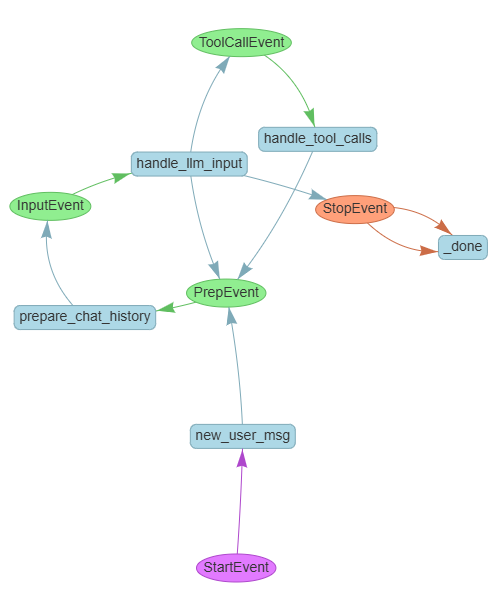

In [42]:
print(agent.llm.system_prompt)
print(agent)

None


In [57]:
from llama_index.core.tools import FunctionTool
from llama_index.llms.openai import OpenAI


def add(x: int, y: int) -> int:
    """Useful function to add two numbers."""
    return x + y


def multiply(x: int, y: int) -> int:
    """Useful function to multiply two numbers."""
    return x * y


tools = [
    FunctionTool.from_defaults(add),
    FunctionTool.from_defaults(multiply),
]

agent = ReActAgent(
    llm=OpenAI(model="gpt-4o-mini"), tools=tools, timeout=120, verbose=True
)

ret = await agent.run(input="Hello!")

Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event StopEvent


In [6]:
print(ret["response"])

Hello! How can I assist you today?
```


In [58]:
ret = await agent.run(input="What is (2123 + 2321) * 312?")


Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event StopEvent


In [8]:
print(ret["response"])

The result of (2123 + 2321) * 312 is 1,386,528.


In [10]:
import wikipedia
from pydantic import BaseModel
from llama_index.core.tools import FunctionTool
from llama_index.llms.openai import OpenAI
from typing import Dict

def wikipedia_similar_articles(query: str) -> list[Dict[str,str]]:
    """Search Wikipedia for articles similar to the given query and return titles and URLs."""
    search_results = wikipedia.search(query, results=10)
    result_list = []
    for result in search_results:
        try:
            page = wikipedia.page(result)
            result_list.append({"title": page.title, "url": page.url})
        except wikipedia.exceptions.DisambiguationError as e:
            # Handle disambiguation pages by logging or ignoring
            print(f"Disambiguation page: {e.options}")
        except wikipedia.exceptions.PageError:
            print(f"PageError: {result}")
    return result_list



def wikipedia_full_article(query: str) -> Dict[str,str]:
    """Fetch the full Wikipedia article for the given query."""
    try:
        page = wikipedia.page(query)
        print(page.content)
        return {"title": page.title, "content": page.content, "url": page.url}
    except wikipedia.exceptions.DisambiguationError as e:
        # Handle disambiguation pages
        print(f"Disambiguation page: {e.options}")
    except wikipedia.exceptions.PageError:
        print(f"PageError: {query}")
    return None

# Wrap these functions in a tool
similar_articles_tool = FunctionTool.from_defaults(fn=wikipedia_similar_articles)
full_article_tool = FunctionTool.from_defaults(fn=wikipedia_full_article)

In [11]:
agent = ReActAgent(
    llm=OpenAI(model="gpt-4o"), tools=[similar_articles_tool, full_article_tool], timeout=120, verbose=True
)

ret = await agent.run(input="Who is the president?")
print(ret)

Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
The president of the United States (POTUS) is the head of state and head of government of the United States of America. The president directs the executive branch of the federal government and is the commander-in-chief of the United States Armed Forces.
The power of the presidency has grown substantially since the first president, George Washington, took office in 1789. While presidential power has ebbed and flowed over time, the presidency has played an increasingly significant role in American political life since the beginning of the 20th century, carrying over into the 21st century with notable expansions during the presidencies of Franklin D. Roosevelt and George W. Bush. In modern times, the president is one of the wo

In [9]:
response = await agent.run(input="Who scored the most goals in the European Champion's League in 2020?")
print(response)

Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event StopEvent
{'response': 'The top goalscorer of the 2019–20 UEFA Champions League was Robert Lewandowski, who scored 15 goals for Bayern Munich.', 'sources': [ToolOutput(content='{\'title\': \'2020–21 UEFA Champions League\', \'content\': \'The 2020–21 UEFA Champions League was the 66th 

In [14]:
response = await agent.run(input="What about the 2020-2021 season?")
print(response)

Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_c

In [15]:
response = await agent.run(input="Give me some articles similar to the Eiffel Tower")
print(response)

Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls


/mnt/c/Users/mwp89/Desktop/envs/wiki_search_env/lib/python3.9/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /mnt/c/Users/mwp89/Desktop/envs/wiki_search_env/lib/python3.9/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Disambiguation page: ['Eiffel Tower (Paris, Tennessee)', 'Eiffel Tower (Paris, Texas)', 'Eiffel Tower (Six Flags)', 'at Paris Las Vegas', 'Tour Eiffel Bridge', 'Eiffel Tower (Delaunay series)', 'EiffelTowers Nijmegen', 'Heroes Den Bosch', 'Tour Eiffel (disambiguation)', 'List of Eiffel Tower replicas', 'Eiffel (disambiguation)', 'Tower (disambiguation)', 'All pages with titles beginning with Eiffel Tower', 'All pages with titles containing Eiffel Tower']
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event StopEvent
{'response': 'Here are some articles similar to the Eiffel Tower:\n\n1. [Eiffel Tower](https://en.wikipedia.org/wiki/Eiffel_Tower)\n2. [Eiffel Tower replicas and derivatives](https://en.wikipedia.org/wiki/Eiffel_Tower_replicas_and_derivatives)\n3. [List of the 72 names on the Eiffel Tower](https://en.wikipedia.org/wiki/List_of_t

In [ ]:
# create a semantic search index across wikipedia article titles?
# create graph visualization 
# understand the full workflow
# get phoenix arize working - modular evaluation + feedback loop
# add end-to-end tests with ragas (faithfulness) ie) is the answer supported by the context?


In [22]:
from llama_index.core.workflow import draw_all_possible_flows

draw_all_possible_flows(ReActAgent, filename="react_agent_workflow.html")

/tmp/ipykernel_27389/1870851596.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) draw_all_possible_flows. (Install `llama-index-utils-workflow` and use the import `from llama_index.utils.workflow` instead.)
  draw_all_possible_flows(ReActAgent, filename="react_agent_workflow.html")


react_agent_workflow.html


In [23]:
print(agent.memory)

chat_store=SimpleChatStore(store={'chat_history': [ChatMessage(role=<MessageRole.USER: 'user'>, content='Who is the president?', additional_kwargs={}), ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, content='The current president of the United States is Joe Biden, who assumed office on January 20, 2021.', additional_kwargs={}), ChatMessage(role=<MessageRole.USER: 'user'>, content="Who scored the most goals in the European Champion's League in 2020?", additional_kwargs={}), ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, content='The top goal scorer in the UEFA Champions League for the 2019-2020 season was Robert Lewandowski of Bayern Munich, who scored 15 goals.', additional_kwargs={}), ChatMessage(role=<MessageRole.USER: 'user'>, content='What about the 2021-2022 season?', additional_kwargs={}), ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, content='The top goal scorer in the UEFA Champions League for the 2021-2022 season was Karim Benzema of Real Madrid, who s

In [24]:
print(agent.sources)

[ToolOutput(content="[{'title': 'Eiffel Tower', 'url': 'https://en.wikipedia.org/wiki/Eiffel_Tower'}, {'title': 'Eiffel Tower replicas and derivatives', 'url': 'https://en.wikipedia.org/wiki/Eiffel_Tower_replicas_and_derivatives'}, {'title': 'List of the 72 names on the Eiffel Tower', 'url': 'https://en.wikipedia.org/wiki/List_of_the_72_names_on_the_Eiffel_Tower'}, {'title': 'Gustave Eiffel', 'url': 'https://en.wikipedia.org/wiki/Gustave_Eiffel'}]", tool_name='wikipedia_similar_articles', raw_input={'args': (), 'kwargs': {'query': 'Eiffel Tower'}}, raw_output=[{'title': 'Eiffel Tower', 'url': 'https://en.wikipedia.org/wiki/Eiffel_Tower'}, {'title': 'Eiffel Tower replicas and derivatives', 'url': 'https://en.wikipedia.org/wiki/Eiffel_Tower_replicas_and_derivatives'}, {'title': 'List of the 72 names on the Eiffel Tower', 'url': 'https://en.wikipedia.org/wiki/List_of_the_72_names_on_the_Eiffel_Tower'}, {'title': 'Gustave Eiffel', 'url': 'https://en.wikipedia.org/wiki/Gustave_Eiffel'}], is

In [26]:
response = await agent.run(input="What tools do you have available?")
print(response)

Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
Step handle_llm_input produced event StopEvent
{'response': 'I have the following tools available:\n\n1. **wikipedia_similar_articles**: This tool searches Wikipedia for articles similar to a given query and returns titles and URLs.\n2. **wikipedia_full_article**: This tool fetches the full Wikipedia article for a given query.\n\nYou can ask me to use any of these tools to help you with your queries.', 'sources': [], 'reasoning': [ResponseReasoningStep(thought='(Implicit) I can answer without any more tools!', response='I have the following tools available:\n\n1. **wikipedia_similar_articles**: This tool searches Wikipedia for articles similar to a given query and returns titles and URLs.\n2. **wikipedia_full_article**: This tool fetches the full Wikipedia article for a given query.\n\nYou can ask me to 

In [63]:
# system prompt
print(agent.formatter.system_header)


You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.

## Tools

You have access to a wide variety of tools. You are responsible for using the tools in any sequence you deem appropriate to complete the task at hand.
This may require breaking the task into subtasks and using different tools to complete each subtask.

You have access to the following tools:
{tool_desc}


## Output Format

Please answer in the same language as the question and use the following format:

```
Thought: The current language of the user is: (user's language). I need to use a tool to help me answer the question.
Action: tool name (one of {tool_names}) if using a tool.
Action Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})
```

Please ALWAYS start with a Thought.

NEVER surround your response with markdown code markers. You may use code markers within your response if y